# Initial analysis of CROCO IPBW and PBW simulations

In [30]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

import croco_util

from xhistogram.xarray import histogram

In [6]:
import importlib
importlib.reload(croco_util)

<module 'croco_util' from '/home/561/rmh561/croco_util.py'>

In [2]:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 22.46 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33075,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 22.46 GiB
Comm: tcp://127.0.0.1:38223,Total threads: 1
Dashboard: /proxy/46701/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:35149,


## Some observational products:

In [31]:
OISST = xr.open_mfdataset('/g/data/ua8/NOAA_OISST/AVHRR/v2-1_modified/*.nc',concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True)

In [32]:
CMEMS = xr.open_mfdataset('/g/data/ua8/CMEMS_SeaLevel/v2019/****/*.nc',concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True)

In [11]:
depths = (0,300)    # Define depth range for all plots [m]

EqPlons = (-217,-95) # Define longitude range for longitude-depth plot [degrees]
EqPlat = 0.         # Define latitude for longitude-depth plot [degrees]

Ltlon = -140.       # Define longitude for latitude-depth plot [degrees]
ObsLtlon = 220.     # Define longitude for latitude-depth plot for Johnson observations. [degrees]
Ltlats = (-8,10)    # Define latitudes for latitude-depth plot [degrees]

In [12]:
# Define Johnson observations file:
obs_file = xr.open_dataset('/g/data/ik11/observations/Johnson2002/meanfit_m.cdf')

# Extract temperature:
obs_temp = obs_file['POTEMPM']
obs_temp_eq = obs_temp.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(YLAT11_101=EqPlat, method='nearest')
obs_temp_140w = obs_temp.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(XLON=ObsLtlon, method='nearest')
lat_obs = obs_temp_140w.YLAT11_101
lon_obs = obs_temp_eq.XLON
dep_obs = obs_temp_eq.ZDEP1_50

# Extract zonal velocity:
obs_u = obs_file['UM']
obs_u_eq = obs_u.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(YLAT11_101=EqPlat, method='nearest')
obs_u_140w = obs_u.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(XLON=ObsLtlon, method='nearest')
lat_u_obs = obs_u_140w.YLAT11_101
lon_u_obs = obs_u_eq.XLON

In [4]:
# CROCOTOOLS datasets:
SSTpath = xr.open_dataset('/g/data/e14/rmh561/croco/data/DATASETS_CROCOTOOLS/SST_pathfinder/climato_pathfinder.nc')
WOA09T = xr.open_dataset('/g/data/e14/rmh561/croco/data/DATASETS_CROCOTOOLS/WOA2009/temp_month.cdf') 
WOA09S = xr.open_dataset('/g/data/e14/rmh561/croco/data/DATASETS_CROCOTOOLS/WOA2009/salt_month.cdf')

# Roll longitudes:
SSTpath = SSTpath.roll(X=2048, roll_coords=True);
SSTpath = SSTpath.assign_coords(X=np.where(SSTpath.X.values>=0.,SSTpath.X.values-360.,SSTpath.X.values))

WOA09T = WOA09T.roll(X=180, roll_coords=True);
WOA09T = WOA09T.assign_coords(X=np.where(WOA09T.X.values>=0.,WOA09T.X.values-360.,WOA09T.X.values))

WOA09S = WOA09S.roll(X=180, roll_coords=True);
WOA09S = WOA09S.assign_coords(X=np.where(WOA09S.X.values>=0.,WOA09S.X.values-360.,WOA09S.X.values))

## Load data files and add some extra information (e.g. binning)

In [7]:
# files:
# base = '/g/data/e14/rmh561/croco/archive/IPBW/';
base = '/g/data/e14/rmh561/croco/archive/PBW/';
favg = xr.open_dataset(base + 'croco_avg_02.nc').chunk({'time': 1})

# Generate xgcm grid object:
grid = Grid(favg,coords={"xi":{"center":"xi_rho","inner":"xi_u"},
                         "eta":{"center":"eta_rho","inner":"eta_v"},
                         "s":{"center":"s_rho","outer":"s_w"}},periodic=False)
lon_rho1 = favg.lon_rho.isel(eta_rho=0)
lat_rho1 = favg.lat_rho.isel(xi_rho=0)
lon_u1 = favg.lon_u.isel(eta_rho=0)
lat_v1 = favg.lat_v.isel(xi_rho=0)

favg = favg.assign_coords({"lat_rho1":("eta_rho",lat_rho1.data),"lon_rho1" : ("xi_rho",lon_rho1.data),"lat_v1":("eta_v",lat_v1.data),"lon_u1" : ("xi_u",lon_u1.data)})

# Do vertical coords calculations:
favg["z_rho"] = croco_util.calc_z('r',favg)
favg["z_w"] = croco_util.calc_z('w',favg)

In [9]:
# Restrict obs. products:
SSTpath = SSTpath.sel(X=slice(lon_rho1.min().values,lon_rho1.max().values)).sel(Y=slice(lat_rho1.min().values,lat_rho1.max().values))
WOA09T = WOA09T.sel(X=slice(lon_rho1.min().values,lon_rho1.max().values)).sel(Y=slice(lat_rho1.min().values,lat_rho1.max().values))
WOA09S = WOA09S.sel(X=slice(lon_rho1.min().values,lon_rho1.max().values)).sel(Y=slice(lat_rho1.min().values,lat_rho1.max().values))

## Mean SST bias:

<a list of 179 text.Text objects>

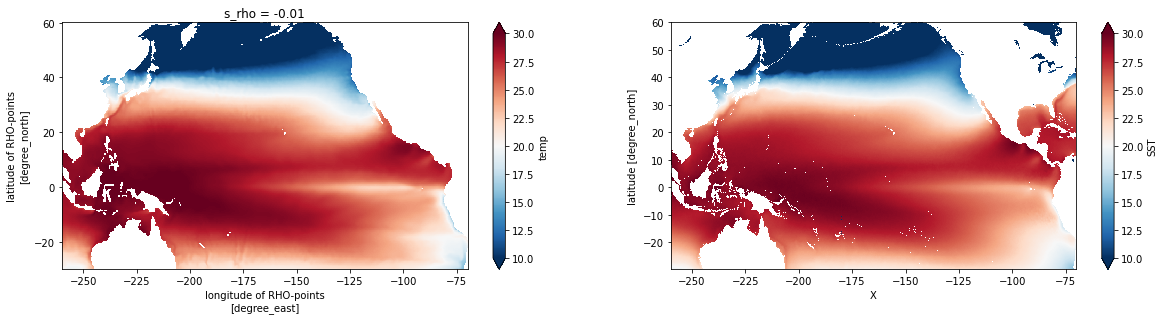

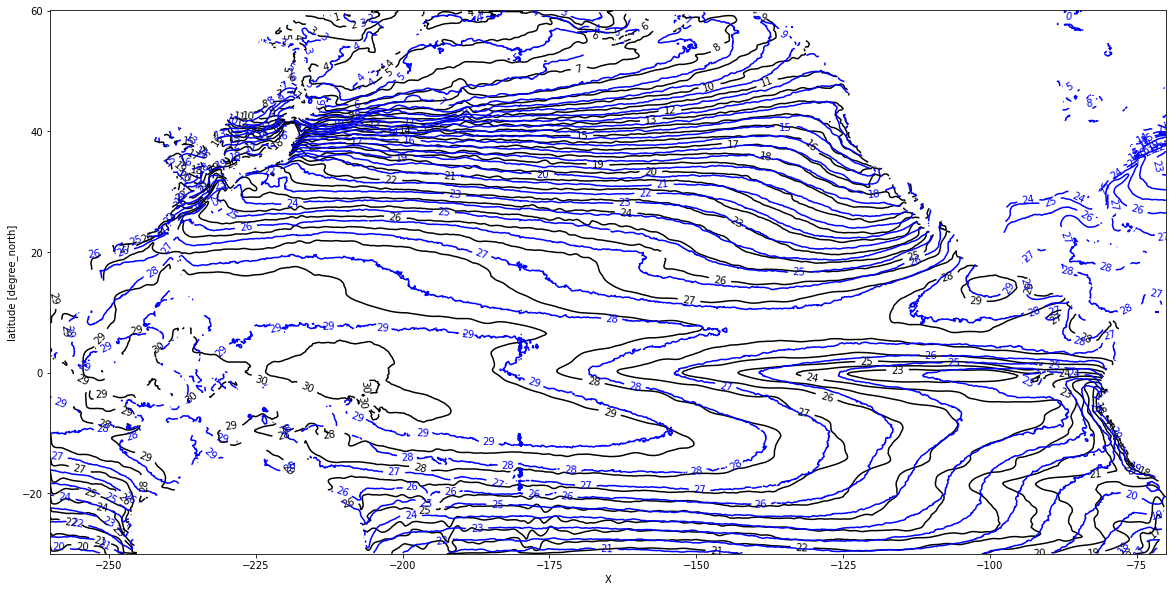

In [53]:
SSTmean = favg.temp.isel(s_rho=-1).mean('time').where(SSTmean!=0.,np.nan)

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
SSTmean.plot(x="lon_rho",y="lat_rho",vmin=10.,vmax=30.,cmap='RdBu_r')

plt.subplot(2,2,2)
SSTpath.SST.mean('T').plot(vmin=10.,vmax=30.,cmap='RdBu_r')

plt.figure(figsize=(20,10))

CS = SSTmean.plot.contour(x="lon_rho",y="lat_rho",levels=np.arange(0.,33.,1.),colors='k')
plt.gca().clabel(CS, inline=1, fontsize=10)

CS = SSTpath.SST.mean('T').plot.contour(levels=np.arange(0.,33.,1.),colors='b')
plt.gca().clabel(CS, inline=1, fontsize=10)

# 140W and equatorial slices compared to Johnson climatology

In [13]:
xind = abs(favg.lon_rho1+140.).argmin().values
yind = abs(favg.lat_rho1).argmin().values

# 140W depth-lat
u_140w = favg.u.isel(xi_u=xind).mean('time')
temp_140w = favg.temp.isel(xi_rho=xind).mean('time')
z_140w = favg.z_rho.isel(time=0).isel(xi_rho=xind)

# Equatorial depth-longitude:
u_eq = favg.u.isel(eta_rho=yind).mean('time')
temp_eq = favg.temp.isel(eta_rho=yind).mean('time')
z_eq = favg.z_rho.isel(time=0).isel(eta_rho=yind)

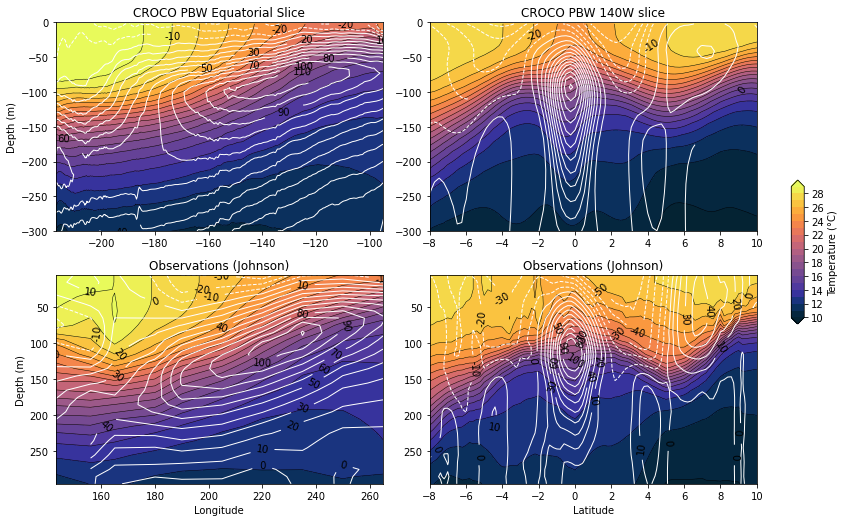

In [24]:
# Define colobar limits and labels:
clevelsT = np.arange(10.,30.,1.)
clevelsU = np.arange(-50,130,10)

fig = plt.figure(figsize=(12,8))

# Plot equatorial slice:
plt.subplot(2,2,1)
xv, yv = np.meshgrid(temp_eq.lon_rho1,z_eq.isel(xi_rho=0))
p1=plt.contourf(xv,z_eq,temp_eq,cmap=cm.cm.thermal, 
                               levels=clevelsT,
                               add_colorbar=False, extend='both')
plt.contour(xv,z_eq,temp_eq,levels=clevelsT,colors='k',linewidths=0.5)
xv, yv = np.meshgrid(u_eq.lon_u1,z_eq.isel(xi_rho=0))
p2=plt.contour(xv,z_eq.isel(xi_rho=slice(0,-1)),100*u_eq,colors='w',levels=clevelsU,linewidths=1)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.ylim([-300.,0.])
plt.xlim(EqPlons)
#plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.title('CROCO PBW Equatorial Slice')


# Plot latitude-depth slice:
plt.subplot(2,2,2)
xv, yv = np.meshgrid(temp_140w.lat_rho1,z_140w.isel(eta_rho=0))
p3=plt.contourf(xv,z_140w,temp_140w,cmap=cm.cm.thermal, 
                               levels=clevelsT,
                               add_colorbar=False, extend='both')
plt.contour(xv,z_140w,temp_140w,levels=clevelsT,colors='k',linewidths=0.5)
xv, yv = np.meshgrid(u_140w.lat_rho1,z_140w.isel(eta_rho=0))
p4=plt.contour(xv,z_140w,100*u_140w,colors='w',levels=clevelsU,linewidths=1)
plt.clabel(p4, fmt='%2.0f', colors='black', fontsize=10)
plt.ylim([-300.,0.])
plt.xlim(Ltlats)
#plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('')
plt.title('CROCO PBW 140W slice')

# Plot observational equatorial slice:
plt.subplot(2,2,3)
p1 = plt.contourf(lon_obs, dep_obs, obs_temp_eq, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lon_obs, dep_obs, obs_temp_eq, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lon_u_obs, dep_obs, obs_u_eq*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Longitude')
plt.ylabel('Depth (m)')
plt.title('Observations (Johnson)')

# Plot observational latitude-depth slice:
plt.subplot(2,2,4)
p1 = plt.contourf(lat_obs, dep_obs, obs_temp_140w, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lat_obs, dep_obs, obs_temp_140w, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lat_u_obs, dep_obs, obs_u_140w*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('')
plt.title('Observations (Johnson)')

# Add colorbar:
ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical', extend='both')
cb.ax.set_ylabel('Temperature (°C)')
fig.tight_layout(rect=[0, 0.03, 0.9, 0.95])
plt.savefig('CROCO_PBW_Johnson_Comparison.png',dpi=150)

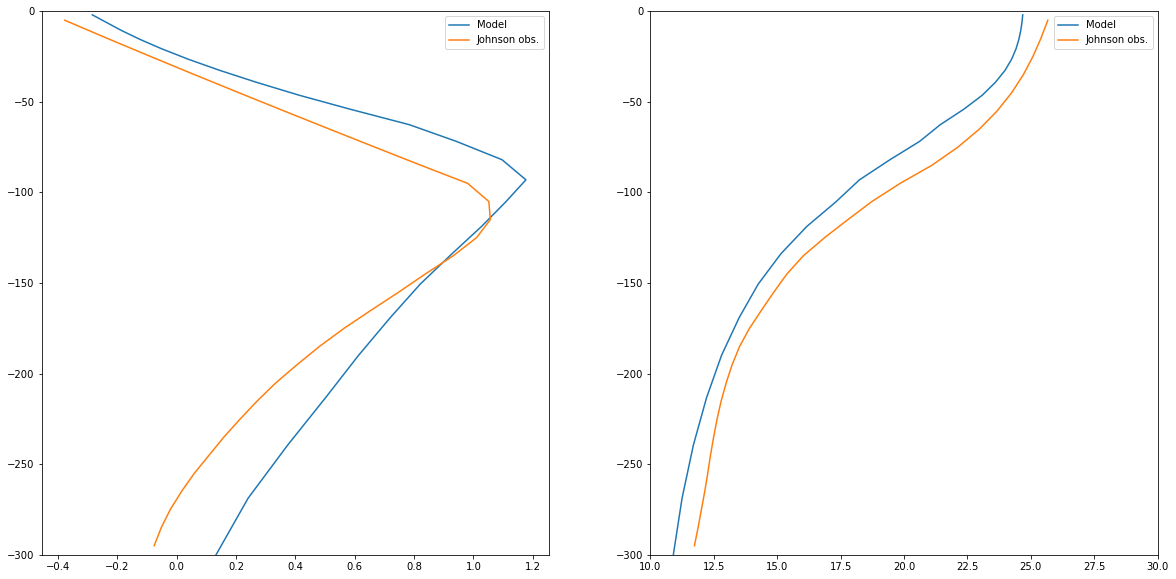

In [14]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(u_140w.isel(eta_rho=yind),z_140w.isel(eta_rho=yind),label='Model')
plt.plot(obs_u_140w.sel(YLAT11_101=0.),-dep_obs,label='Johnson obs.')
plt.ylim([-300.,0.])
plt.legend()

plt.subplot(1,2,2)
plt.plot(temp_140w.isel(eta_rho=yind),z_140w.isel(eta_rho=yind),label='Model')
plt.plot(obs_temp_140w.sel(YLAT11_101=0.),-dep_obs,label='Johnson obs.')
plt.ylim([-300.,0.])
plt.xlim([10.,30.])
plt.legend()

## TIW SST/SSH variability

In [34]:
# Select regions for high-pass longitude filtered analysis:
ln_hp_filt = 12.0

xr = -170.,-100.
xrf = xr[0]-ln_hp_filt/2.,xr[1]+ln_hp_filt/2.
yr = -2.,10.

xind1 = abs(favg.lon_rho1-xrf[0]).argmin().values
yind1 = abs(favg.lat_rho1-yr[0]).argmin().values
xind2 = abs(favg.lon_rho1-xrf[1]).argmin().values
yind2 = abs(favg.lat_rho1-yr[1]).argmin().values

sst = favg.temp.isel(s_rho=-1)
ssh = favg.zeta
sst = sst.isel(xi_rho=slice(xind1,xind2)).isel(eta_rho=slice(yind1,yind2))
ssh = ssh.isel(xi_rho=slice(xind1,xind2)).isel(eta_rho=slice(yind1,yind2))

In [35]:
# Do high-pass filtering:
sst_hp = (sst-sst.rolling(xi_rho=int(ln_hp_filt/(1./4.)),center=True).mean())
sst_hp_std = sst_hp.std('time')
sst_hp_std.load()

ssh_hp = (ssh-ssh.rolling(xi_rho=int(ln_hp_filt/(1./4.)),center=True).mean())
ssh_hp_std = ssh_hp.std('time')
ssh_hp_std.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'zeta' (eta_rho: 48, xi_rho: 328)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * xi_rho    (xi_rho) float32 4.0 5.0 6.0 7.0 8.0 ... 39.0 40.0 41.0 42.0 43.0
  * eta_rho   (eta_rho) float32 24.0 25.0 26.0 27.0 28.0 ... 20.0 21.0 22.0 23.0
    lon_rho   (eta_rho, xi_rho) float32 -176.0 -175.8 -175.5 ... -94.5 -94.25
    lat_rho   (eta_rho, xi_rho) float32 -1.99 -1.99 -1.99 ... 9.714 9.714 9.714
    lat_rho1  (eta_rho) float32 -1.99 -1.741 -1.491 -1.241 ... 9.221 9.467 9.714
    lon_rho1  (xi_rho) float32 -176.0 -175.8 -175.5 ... -94.75 -94.5 -94.25

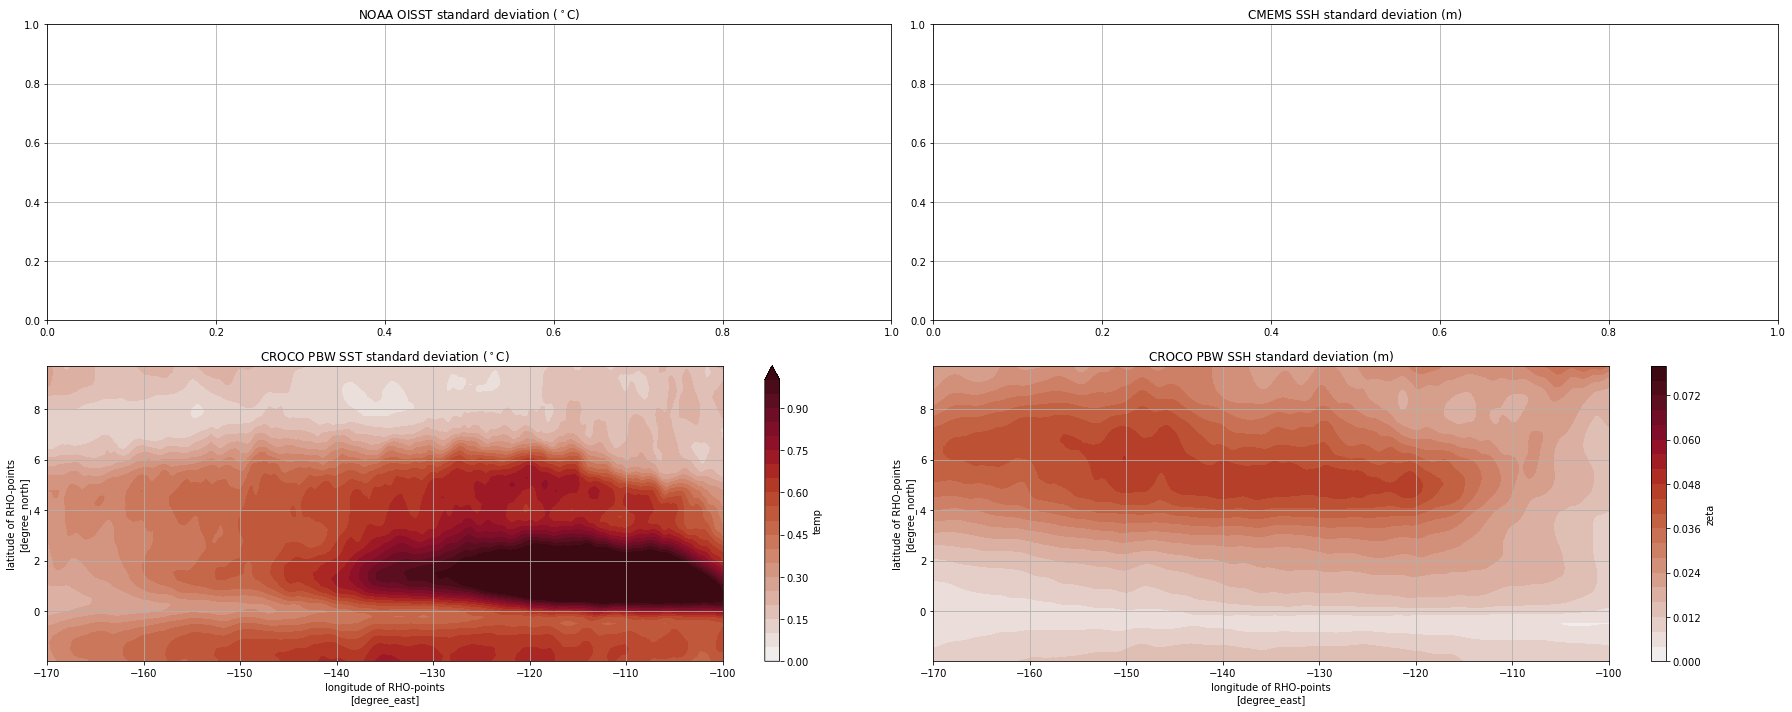

In [48]:
tlims = 0.,1.
zlims = 0.,0.08
tsp = tlims[1]/20.
zsp = zlims[1]/20.

xind1 = abs(favg.lon_rho1-xr[0]).argmin().values
xind2 = abs(favg.lon_rho1-xr[1]).argmin().values

# Do the plotting:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(25,10))
#sst_obs_hp_std.sel(lon=slice(xr[0]+360.,xr[1]+360.)).plot.contourf(ax=axes[0][0],levels=np.arange(tlims[0],tlims[1]+tsp,tsp),cmap=cm.cm.amp)
#ssh_obs_hp_std.sel(longitude=slice(xr[0]+360.,xr[1]+360.)).plot.contourf(ax=axes[0][1],levels=np.arange(zlims[0],zlims[1]+zsp,zsp),cmap=cm.cm.amp)
sst_hp_std.plot.contourf(ax=axes[1][0],x="lon_rho",y="lat_rho",levels=np.arange(tlims[0],tlims[1]+tsp,tsp),cmap=cm.cm.amp)
ssh_hp_std.plot.contourf(ax=axes[1][1],x="lon_rho",y="lat_rho",levels=np.arange(zlims[0],zlims[1]+zsp,zsp),cmap=cm.cm.amp)
    
axes[0][0].set_title('NOAA OISST standard deviation ($^\circ$C)')
axes[0][1].set_title('CMEMS SSH standard deviation (m)')
axes[1][0].set_title('CROCO PBW SST standard deviation ($^\circ$C)')
axes[1][1].set_title('CROCO PBW SSH standard deviation (m)')
axes[1][0].set_xlim([xr[0],xr[1]])
axes[1][1].set_xlim([xr[0],xr[1]])
axes[0][0].grid()
axes[0][1].grid()
axes[1][0].grid()
axes[1][1].grid()
plt.tight_layout()
plt.savefig('CROCO_SSH_SST_FiltPlot_025deg.png',dpi=300)

## Vertically-integrated transport

In [5]:
# Calculate total y-transport:
ty_trans = grid.interp(favg.h/favg.pm,'eta')*favg.vbar

lon = favg.lon_rho.isel(eta_rho=0)
lat = favg.lat_v.isel(xi_rho=0)
ty_trans = ty_trans.assign_coords({"lat":lat,"lon" : lon})
ty_trans.load()

<xarray.DataArray (eta_v: 428, xi_rho: 761, time: 360)>
array([[[ -165335.89  ,  -231893.1   ,  -307141.94  , ...,
          -975454.2   , -1006549.9   , -1033244.75  ],
        [   55739.71  ,    -7184.8643,   -67876.98  , ...,
          -225328.23  ,  -245557.16  ,  -261619.44  ],
        [   53460.984 ,    -5961.654 ,   -64718.605 , ...,
          -194962.1   ,  -211371.88  ,  -234354.52  ],
        ...,
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ]],

       [[ -388407.2   ,  -458959.53  ,  -549228.94  , ...,
         -1734492.2   , -1776671.2   , -1814191.6   ],
        [ -388421.56  ,  -458989.66  ,  -549263.44  , ...,
         -1734496.    , -1776674.1   , -1814208.5   ],
        [ -365551.8   ,  -417678.3   ,  -493094.5   , ...,
         -1487299.9   , -1530040.    , -1583370.4   ],
...
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ]],

       [[       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        ...,
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ]]], dtype=float32)
Coordinates:
  * eta_v    (eta_v) float32 1.5 2.5 3.5 4.5 5.5 ... 42.5 43.5 44.5 45.5 46.5
  * xi_rho   (xi_rho) float32 1.0 2.0 3.0 4.0 5.0 ... 40.0 41.0 42.0 43.0 44.0
    lon_v    (eta_v) float32 -260.0 -260.0 -260.0 ... -260.0 -260.0 -260.0
    lat_v    (eta_v) float32 -29.89 -29.68 -29.46 -29.24 ... 59.76 59.88 60.01
  * time     (time) float64 3.132e+07 3.175e+07 3.218e+07 ... 1.86e+08 1.864e+08
    lat      (eta_v) float32 -29.89 -29.68 -29.46 -29.24 ... 59.76 59.88 60.01
    eta_rho  float32 1.0
    lon_rho  (xi_rho) float32 -260.0 -259.8 -259.5 -259.2 ... -70.5 -70.25 -70.0
    lat_rho  (xi_rho) float32 -30.0 -30.0 -30.0 -30.0 ... -30.0 -30.0 -30.0
    lon      (xi_rho) float32 -260.0 -259.8 -259.5 -259.2 ... -70.5 -70.25 -70.0

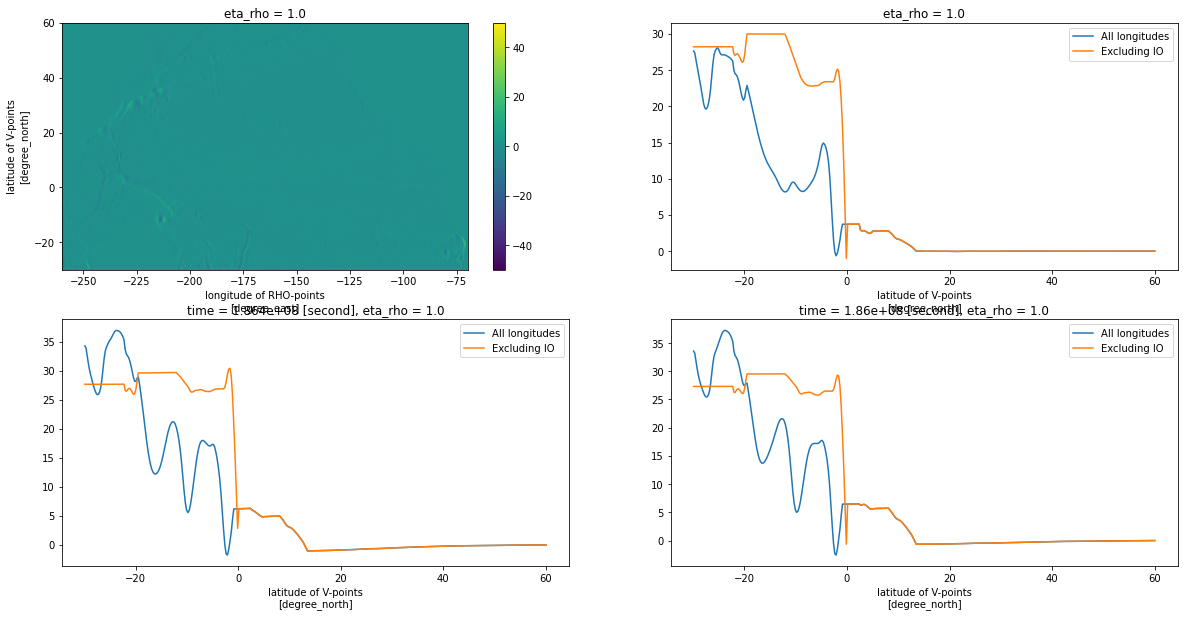

In [9]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
(ty_trans.mean('time')/1.e6).plot(x='lon',y='lat',vmin=-50.,vmax=50.)

plt.subplot(2,2,2)
(ty_trans.sum('xi_rho')/1.e6).mean('time').plot(x='lat',label='All longitudes')
(ty_trans.where(np.logical_or(favg.lon_v>-225.,favg.lat_v>0.)).sum('xi_rho')/1.e6).mean('time').plot(x='lat',label='Excluding IO')
plt.legend()

plt.subplot(2,2,3)
(ty_trans.sum('xi_rho')/1.e6).isel(time=-1).plot(x='lat',label='All longitudes')
(ty_trans.where(np.logical_or(favg.lon_v>-225.,favg.lat_v>0.)).sum('xi_rho')/1.e6).isel(time=-1).plot(x='lat',label='Excluding IO')
plt.legend()

plt.subplot(2,2,4)
(ty_trans.sum('xi_rho')/1.e6).isel(time=-2).plot(x='lat',label='All longitudes')
(ty_trans.where(np.logical_or(favg.lon_v>-225.,favg.lat_v>0.)).sum('xi_rho')/1.e6).isel(time=-2).plot(x='lat',label='Excluding IO')
plt.legend()

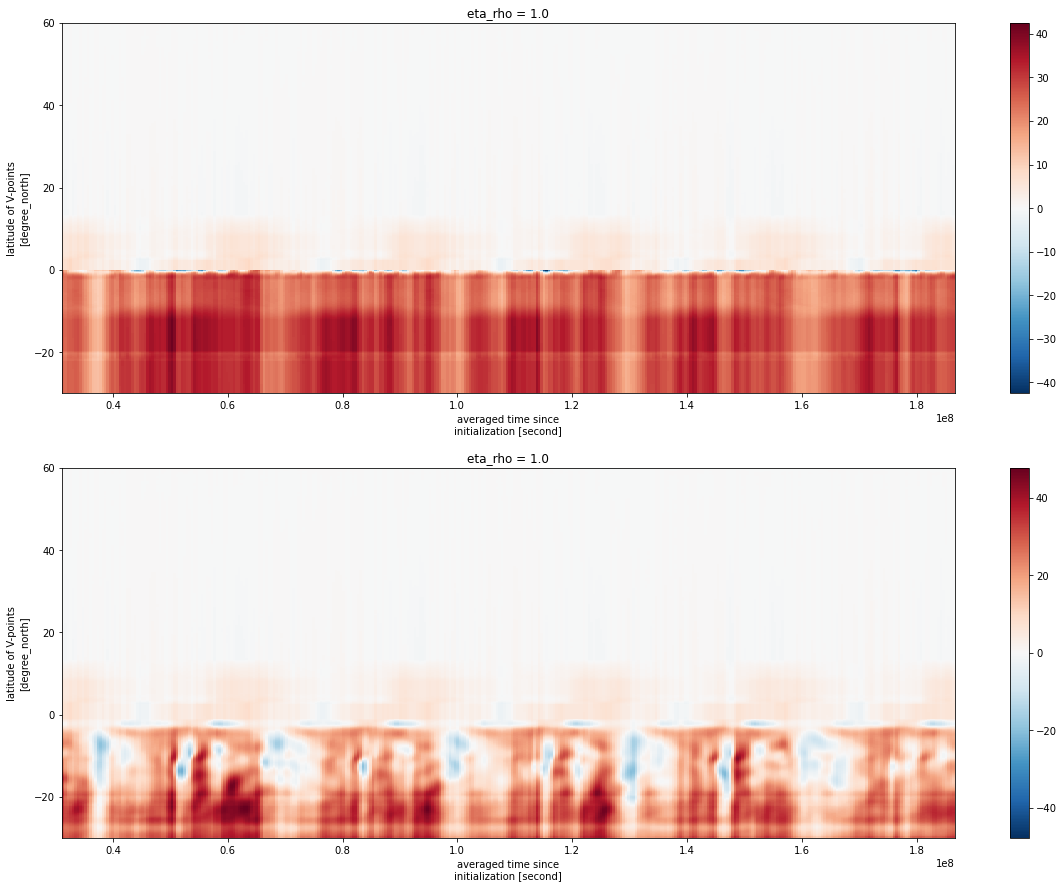

In [12]:
plt.figure(figsize=(20,15))

plt.subplot(2,1,1)
(ty_trans.where(np.logical_or(favg.lon_v>-225.,favg.lat_v>0.)).sum("xi_rho")/1.e6).plot(x='time',y='lat')

plt.subplot(2,1,2)
(ty_trans.sum("xi_rho")/1.e6).plot(x='time',y='lat')

In [4]:
#tx_trans = grid.interp(favg.h/favg.pn,'xi')*favg.ubar
ty_trans = grid.interp(favg.h/favg.pm,'eta')*favg.vbar
#tx_trans = tx_trans.isel(time=slice(50,76)).mean('time')
#ty_trans = ty_trans.isel(time=slice(50,76)).mean('time')
#BTsf = grid.cumsum(tx_trans,'eta',boundary="fill",fill_value=0.)
BTsf = grid.cumsum(ty_trans,'xi',boundary="fill",fill_value=0.)

#lon = favg.lon_u.isel(eta_rho=0)
#lat = favg.lat_v.isel(xi_rho=0)
#BTsf = BTsf.assign_coords({"lat":lat,"lon" : lon})
BTsf = BTsf.assign_coords({"lat":lat,"lon" : lon})
BTsf.load()

lon = favg.lon_rho.isel(eta_rho=0)
lat = favg.lat_v.isel(xi_rho=0)
ty_trans = ty_trans.assign_coords({"lat":lat,"lon" : lon})
ty_trans.load()

lon = favg.lon_u.isel(eta_rho=0)
lat = favg.lat_rho.isel(xi_rho=0)
tx_trans = tx_trans.assign_coords({"lat":lat,"lon" : lon})
tx_trans.load()

<xarray.DataArray (eta_rho: 429, xi_u: 760)>
array([[  270041.4 ,   439629.  ,   731315.8 , ...,        0.  ,
               0.  ,        0.  ],
       [  106262.55,   439633.62,   731322.06, ...,        0.  ,
               0.  , -5641241.5 ],
       [  127515.93,   558236.2 ,   946972.4 , ...,        0.  ,
               0.  , -5653967.5 ],
       ...,
       [       0.  ,        0.  ,        0.  , ...,        0.  ,
               0.  , -2953496.5 ],
       [       0.  ,        0.  ,        0.  , ...,        0.  ,
               0.  , -2941742.2 ],
       [       0.  ,        0.  ,        0.  , ...,        0.  ,
               0.  ,        0.  ]], dtype=float32)
Coordinates:
  * eta_rho  (eta_rho) float32 1.0 2.0 3.0 4.0 5.0 ... 42.0 43.0 44.0 45.0 46.0
  * xi_u     (xi_u) float32 1.5 2.5 3.5 4.5 5.5 6.5 ... 40.5 41.5 42.5 43.5 44.5
    lon_u    (xi_u) float32 -259.9 -259.6 -259.4 -259.1 ... -70.62 -70.38 -70.12
    lat_u    (xi_u) float32 -30.0 -30.0 -30.0 -30.0 ... -30.0 -30.0 -30.0 -30.0
    xi_rho   float32 1.0
    lon_rho  (eta_rho) float32 -260.0 -260.0 -260.0 ... -260.0 -260.0 -260.0
    lat_rho  (eta_rho) float32 -30.0 -29.78 -29.57 -29.35 ... 59.82 59.94 60.07
    lat      (eta_rho) float32 -30.0 -29.78 -29.57 -29.35 ... 59.82 59.94 60.07
    lon      (xi_u) float32 -259.9 -259.6 -259.4 -259.1 ... -70.62 -70.38 -70.12

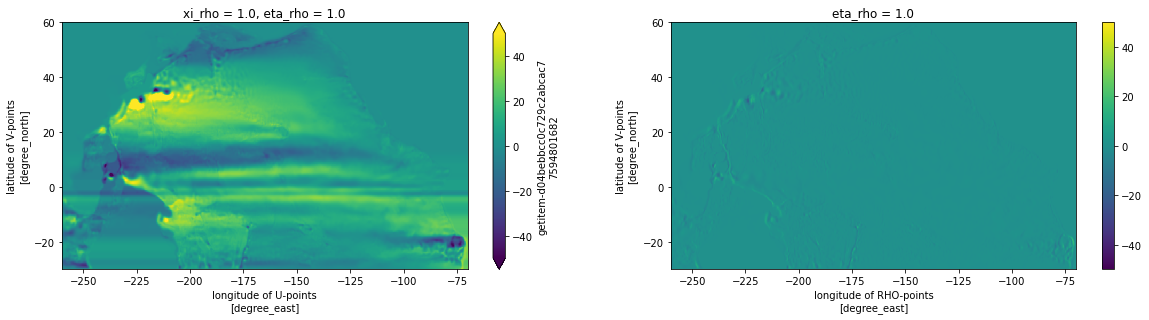

In [5]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
(BTsf/1.e6).plot(x='lon',y='lat',vmin=-50.,vmax=50.)

plt.subplot(2,2,2)
(ty_trans/1.e6).plot(x='lon',y='lat',vmin=-50.,vmax=50.)

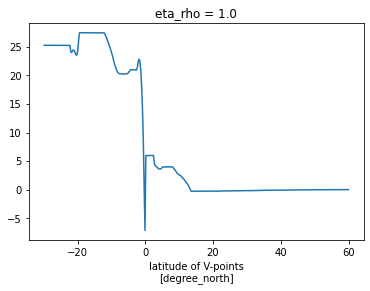

In [13]:
(ty_trans.where(np.logical_or(favg.lon_v>-225.,favg.lat_v>0.)).sum('xi_rho')/1.e6).plot(x='lat')

In [12]:
(ty_trans.where(np.logical_or(favg.lon_v>-225.,favg.lat_v>0.)).sum('xi_rho')/1.e6)

<xarray.DataArray (eta_v: 428)>
dask.array<truediv, shape=(428,), dtype=float32, chunksize=(428,), chunktype=numpy.ndarray>
Coordinates:
  * eta_v    (eta_v) float32 1.5 2.5 3.5 4.5 5.5 ... 42.5 43.5 44.5 45.5 46.5
    lat      (eta_v) float32 -29.89 -29.68 -29.46 -29.24 ... 59.76 59.88 60.01
    eta_rho  float32 1.0

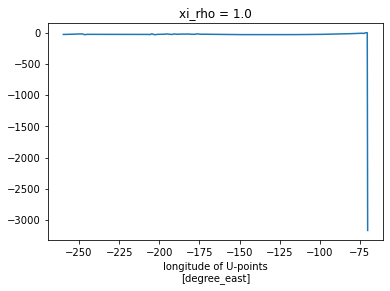

In [7]:
(tx_trans.sum('eta_rho')/1.e6).plot(x='lon')

In [100]:
z_rho = croco_zlevs('r',favg)

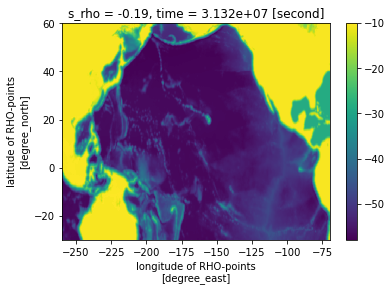

In [106]:
z_rho.isel(time=0).isel(s_rho=-10).plot(x='lon_rho',y='lat_rho')

In [122]:
import croco_utilities

In [128]:
dir(croco_utilities)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'croco_zlevs']